In [1]:
import numpy as np 
from typing import Literal
import matplotlib.pyplot as plt

In [2]:
class NN:

    class Math:
        
        @classmethod
        def _sigmoid(cls, Z: np.ndarray):
            return 1/(1+np.exp(-Z)) 

        @classmethod
        def _sigmoid_derivative(cls, Z: np.ndarray):
            s = cls._sigmoid(Z)
            return s * (1-s) 

        @classmethod
        def _reLU_derivative(cls, Z: np.ndarray):
            return (Z > 0).astype(float)
        
        @classmethod
        def _reLU(cls, Z: np.ndarray):
            return Z * (Z > 0)

        activation_derivative_fun_by_str = {
            "sigmoid": lambda Z: NN.Math._sigmoid_derivative(Z),
            "reLU": lambda Z: NN.Math._reLU_derivative(Z)
        }

        activation_fun_by_str = {
            "sigmoid": lambda Z: NN.Math._sigmoid(Z),
            "reLU": lambda Z: NN.Math._reLU(Z)
        }

    class Layer:
    
        def __init__(self, neurons_amount: int, activation: Literal["sigmoid", "reLU"], is_first: bool=False, show_log_cost: bool = False):

            self.activation_fun = NN.Math.activation_fun_by_str[activation]
            self.activation_derivative_fun = NN.Math.activation_derivative_fun_by_str[activation]
            self.neurons_amount = neurons_amount
            self.activation = activation
            self.is_first = is_first

        def init_params(self):
            self.W = np.random.randn(self.input_amount, self.neurons_amount, )
            self.B = np.zeros((1, self.neurons_amount))
        
        def activate(self, X: np.ndarray):

            # shape: 1 x neurons_amount (row vector)

            self.X = X

            self.Z = self.X @ self.W  + self.B

            self.activations = self.activation_fun(self.Z)     

            return self.activations

        def backward(self, DJ_DA: np.array, lr: float):

            """
                @param: DJ_DA How much the activation of this layer affects the error. DJ_DA might be DJ_DX of the layer ahead (if any), since the activations are used as inputs for the layer ahead.
                @param: lr Learning rate, the percentage of the gradient that we'll use to determine the step size for updating the parameters. Ex.: 0.1 as lr means we'll update in 10% of the gradient, but in reversed direction.
            """

            DJ_DZ = DJ_DA * self.activation_derivative_fun(self.Z)

            DJ_DW = (self.X.transpose(0, 2, 1) @ DJ_DZ )            

            DJ_DX = DJ_DZ @ self.W.transpose(1, 0) if self.is_first == False else 0

            self.W -=  lr *  np.mean(DJ_DW, axis=0)
            self.B -=  lr *  np.mean(DJ_DZ, axis=0)

            return DJ_DX
        

    def __init__(self, layers: list[Layer], input_amount: int, show_log_cost: bool = False):

        self.input_amount = input_amount
        self.show_log_cost = show_log_cost
        self.cost_history = []

        for i, layer in enumerate(layers):

            layer_input_amount = layers[i-1].neurons_amount if i != 0 else self.input_amount

            layer.input_amount = layer_input_amount
            layer.init_params()
            layer.is_first = i == 0

        self.layers = layers

    def add_layer(self, layer: Layer):

        if len(self.layers) != 0:
            layer_input_amount = self.layers[-1].neurons_amount
            is_first = False
        else:
            layer_input_amount = self.input_amount
            is_first = True

            layer.input_amount = layer_input_amount
            layer.init_params()
        layer.is_first = is_first

        self.layers.append(layer)

    def forward_prop(self, input: np.ndarray):

        activations: np.ndarray = input

        for layer in self.layers:
            
            activations = layer.activate(activations)

        return activations
    
    def train(self, X, Y, epochs: int = 100, optimizer = '', batch_percentage = 100, glr = 1, ):

        y_hat = self.forward_prop(X)

        L = len(self.layers)

        for epoch in range(epochs):

            DJ_DA = y_hat - Y

            for i in reversed(range(L)):

                layer = self.layers[i]
                DJ_DA = layer.backward(DJ_DA, glr)

            y_hat = self.forward_prop(X)

            
            if(self.show_log_cost):
                cost = self.cost(y_hat, Y)
                self.cost_history.append(cost)

        return self.cost_history

    def cost(self, y_hat, Y):

        return (1/2) * np.mean((y_hat - Y)**2)
    

    
    def predict(self, X):


        return np.squeeze(self.forward_prop(X))




In [3]:
nn = NN(layers=[

    NN.Layer(neurons_amount=3, activation='sigmoid',),
    NN.Layer(neurons_amount=1, activation='sigmoid',),

], input_amount=2, show_log_cost=True)

In [4]:
X_train_1 = np.array([[0, 0]])
X_train_2 = np.array([[0, 1]])
X_train_3 = np.array([[1, 0]])
X_train_4 = np.array([[1, 1]])

X_train = np.array([X_train_1, X_train_2, X_train_3, X_train_4 ])

Y = np.array([
    [[0]],
    [[1]],
    [[1]],
    [[0]]
    ])

cost_history = nn.train(X_train, Y, epochs=10000, glr=1)



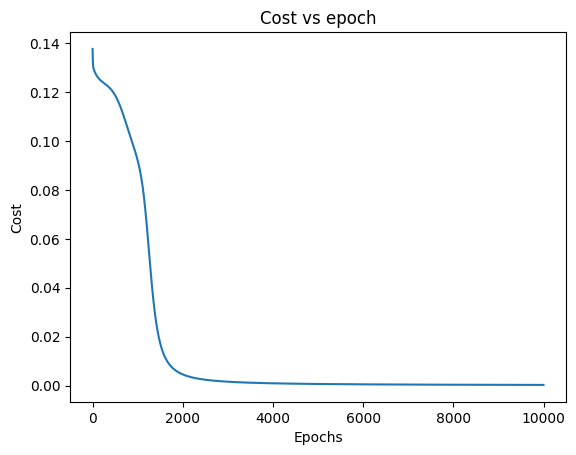

In [5]:
epochs = np.arange(0, 10000)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost vs epoch")
plt.plot(epochs, cost_history)
plt.show()

In [8]:
print("XOR 00: ", nn.predict(X_train_1).round())
print("XOR 01: ", nn.predict(X_train_2).round())
print("XOR 10: ", nn.predict(X_train_3).round())
print("XOR 11: ", nn.predict(X_train_4).round())

print(nn.forward_prop(X_train_1))


XOR 00:  0.0
XOR 01:  1.0
XOR 10:  1.0
XOR 11:  0.0
[[0.02336238]]
